# Classification of Spam

We'll now be exploring the field of Natural Language Processing (NLP), which concerns itself with interpreting, predicting, and classifying the written word. As a first foray into this field, we'll construct a simple spam classifier.

Our goal in this project is to classify text messages as either spam or not spam (also playfully known as "ham" messages). We'll be using a collection of English SMS messages from [Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset/home) as our dataset. First thing to notice is that this dataset is NOT homogeneous! First off, the number of spam/ham messages is unbalanced: only (425+322)=747 spam messages, compared to (3375+450+1002)=4827 ham messages. The other thing is that this data doesn't all come from the same source:

* [Grumbletext](www.grumbletext.co.uk): UK forum for people complaining about spam messages. (425 spam messages)
* [NUS SMS Corpus](www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/): Dataset of legitimate messages collected by the Dept. of Computer Science at the National University of Singapore. Vast majority of messages are from students attending the university. (3375 ham messages)
* [Caroline Tag's PhD thesis](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf): Dataset collected by Caroline Tag during her doctoral studies on the linguistic aspects of texting. (450 ham messages)
* [SMS Spam Corpus v.0.1 Big](http://www.esp.uem.es/jmgomez/smsspamcorpus/): Dataset (itself composed of other datasets) collected by researchers at the Universidad Europea de Madrid. (1002 ham and 322 spam messages)

We'll need to take special care to make sure that the unbalanced nature of the dataset, and the various sources and nationalities of the senders of these messages does not affect the classification. As such, a simple classification accuracy measure will not suffice, as our classifier could still get 4827/(4827+747) = 87% accuracy by just specifying everything as ham and misclassifying every spam sample.

## EDA and data preprocessing
Ok, let's dive in. First, we'll download our dataset and extract the CSV file therein (this requires installing the [Kaggle API](https://github.com/Kaggle/kaggle-api)):

In [23]:
%%bash
kaggle datasets download uciml/sms-spam-collection-dataset --quiet
mkdir -p Data
unzip sms-spam-collection-dataset.zip -d Data
rm sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: Data/spam.csv           


Let's upload this using pandas and take a look at the data.

In [77]:
import pandas as pd
raw_data = pd.read_csv("./Data/spam.csv", encoding="latin") # Need to use latin encoding since UTF throws error
raw_data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


So, looks like the class (spam/ham) is under column "v1", and the actual text of the message is in "v2". What's in the other 3 unnamed columns? Is there even anything in them? Also, you can already tell from this snippet that the use of texting slang is pervasive throughout this corpus. Let's look take a look at the "unnamed" columns.

In [79]:
raw_data[pd.notna(raw_data["Unnamed: 2"]) | pd.notna(raw_data["Unnamed: 3"]) | pd.notna(raw_data["Unnamed: 3"])].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


Looks like the extra columns contain other messages or metadata? Some of it may be relevant to the classification (e.g. it looks like spam messages have some kind of PO box), but it seems like only a very small fraction of the dataset (50/5572=0.9%) has these, so I'm just going to drop these extra columns.

In [86]:
raw_data = raw_data[["v1", "v2"]].rename(columns={"v1": "y", "v2": "msg"})

Now, let's take a look at some summary statistics for the dataset - what is the class balance, number of messages, etc. We'll make use of the python package NLTK (Natural Language ToolKit) to simplify the analysis. First, we'll have to do some tokenization. I'm going to convert all messages to lowercase, then split tokens based on non-alphanumeric characters, discarding the punctuation itself. Also, I'll convert the "spam"/"ham" labels to binary identifiers (where "spam" --> 1).

In [198]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"\w+")

data = []
for _, row in raw_data.iterrows():
    y, msg = row
    y = 0 if (y=="ham") else 1
    msg = msg.lower()
    data.append([y, tokenizer.tokenize(msg)])
data = pd.DataFrame(data, columns=["y", "msg"])
data.head()

,y,msg
0,0,"[go, until, jurong, point, crazy, available, o..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"[nah, i, don, t, think, he, goes, to, usf, he,..."


Now, before we go any further and start to make any more assumptions about how to process the messages, we should split this into training, validation and test sets. Then we'll blind the test set. Even though we haven't got to the typical training procedure yet, any more decisions regarding how to process the data will cross-contaminate the test set so we need to keep it separate. Since we only have a couple thousand data points, I'll use a 80/10/10 train/val/test split to get good statistics when evaluating the validation/test sets.

In [310]:
import numpy as np
np.random.seed(0)
shuffled_data = data.sample(len(data), random_state=0)

# Determine the split
M = len(shuffled_data)
train_idx = int(M*0.80)+1
val_idx = int(M*(0.80+0.10))+1
X_train = shuffled_data["msg"].values[:train_idx]
y_train = shuffled_data["y"].values[:train_idx]
X_val = shuffled_data["msg"].values[train_idx:val_idx]
y_val = shuffled_data["y"].values[train_idx:val_idx]
X_test = shuffled_data["msg"].values[val_idx:]
y_test = shuffled_data["y"].values[val_idx:]

# Check split stats
for name, X, y in [("Training", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
    print(name + " set:")
    M = len(X); nspam = np.sum(y); nham = M - nspam
    print("Size: {}, # spam examples: {} ({:.1f}%), # ham examples: {} ({:.1f}%)\n".format(M, nspam, 100*nspam/M, nham, 100*nham/M))

Training set:
Size: 4458, # spam examples: 601 (13.5%), # ham examples: 3857 (86.5%)

Validation set:
Size: 557, # spam examples: 66 (11.8%), # ham examples: 491 (88.2%)

Test set:
Size: 557, # spam examples: 80 (14.4%), # ham examples: 477 (85.6%)



Now let's compute those summary stats. We'll gather frequency data on all the tokens in the training set.

In [311]:
# Concatenate all tokens together
all_tokens = []
all_spam_tokens = []
all_ham_tokens = []
for x, y in zip(X_train, y_train):
    if (y==1): all_spam_tokens.extend(x)
    elif (y==0): all_ham_tokens.extend(x)
    all_tokens.extend(x)

# Get frequency distribution of words
from nltk.probability import FreqDist
freq_dist = FreqDist(token for token in all_tokens)
spam_freq_dist = FreqDist(token for token in all_spam_tokens)
ham_freq_dist = FreqDist(token for token in all_ham_tokens)

In [312]:
import matplotlib.pyplot as plt

print("Total # of tokens with frequency of at least...")
freq_count = {}
for token in freq_dist:
    f = freq_dist[token]
    freq_count[f] = freq_count.get(f, 0) + 1
freq_counts = [sum([freq_count[f] for f in freq_count if f >= n]) for n in [1,2,3,4,5,10,50,100]]
print("".join([str(n)+": {}, " for n in [1,2,3,4,5,10,50,100]]).format(*freq_counts), end="\n\n")
print("Most frequent tokens (both spam/ham):")
freq_dist.tabulate(20)
print("\nMost freqent spam tokens:")
spam_freq_dist.tabulate(20)
print("\nMost frequent ham tokens:")
ham_freq_dist.tabulate(20)
print("\nLEAST frequent tokens:")
FreqDist(dict(freq_dist.most_common()[-10:])).tabulate()

Total # of tokens with frequency of at least...
1: 7790, 2: 3793, 3: 2535, 4: 1969, 5: 1645, 10: 914, 50: 220, 100: 118, 

Most frequent tokens (both spam/ham):
   i   to  you    a  the    u  and   in   is   me   my   it  for your   of call    s that have   on 
2388 1800 1761 1161 1067  942  783  716  712  648  614  590  561  555  482  473  461  459  444  441 

Most freqent spam tokens:
  to    a call    å  you your  the    2 free  for  now   or  txt    u   is   on   ur    4 have  and 
 552  288  274  244  238  220  176  169  168  168  161  150  133  132  128  119  117  115  103  103 

Most frequent ham tokens:
   i  you   to  the    a    u  and   in   me   my   is   it that   of  for    s   so  but  can have 
2337 1523 1248  891  873  810  680  652  624  607  584  561  442  405  393  385  365  359  357  341 

LEAST frequent tokens:
     mega      asda    counts    toyota     camry olayiwola   mileage   landing      kane      shud 
        1         1         1         1         1     

Looking at the number of tokens with a given count, we can see that the vast majority of distinct tokens only appear a handful of times throughout the entire corpus. This means that we can safely ignore tokens that have counts less than a small number (say, 5?) because they are not distinctive enough to discriminate against in classification.

Looking at the most frequent tokens, we can see that "stop words" such as "i", "to", "you", etc. appear quite often; however, the most frequent spam tokens are not exactly the same as the most frequent ham tokens! For example, the token "i" is the most frequent ham token, yet it doesn't even appear on the top 20 list of spam tokens. Likewise, the token "å" is one of the top 5 spam tokens, yet doesn't appear in the top 20 ham tokens.

But just because a token is frequent throughout the corpus doesn't mean it appear in most messages (i.e. it has a high "document frequency"). Let's take a look at the document frequency and token frequency of the union of the top 10 tokens in either set:

In [313]:
_ = [dist.most_common(10) for dist in [spam_freq_dist, ham_freq_dist]]
for t in {item[0] for sublist in _ for item in sublist}:
    spam_doc_freq = sum([(t in x) for x in X_train[y_train==1]])/len(X_train[y_train==1])
    ham_doc_freq = sum([(t in x) for x in X_train[y_train!=1]])/len(X_train[y_train!=1])
    print("'{}' - spam document frequency: {:.1f}%, ham document frequency: {:.1f}%".format(t, 100*spam_doc_freq, 100*ham_doc_freq))
    print("\tspam token frequency: {:.1f}%, ham token frequency: {:.1f}%".format(100*spam_freq_dist.freq(t), 100*ham_freq_dist.freq(t)), end="\n\n")

'me' - spam document frequency: 3.7%, ham document frequency: 13.7%
	spam token frequency: 0.2%, ham token frequency: 1.1%

'the' - spam document frequency: 24.0%, ham document frequency: 17.8%
	spam token frequency: 1.1%, ham token frequency: 1.6%

'for' - spam document frequency: 24.5%, ham document frequency: 9.1%
	spam token frequency: 1.1%, ham token frequency: 0.7%

'i' - spam document frequency: 6.0%, ham document frequency: 41.9%
	spam token frequency: 0.3%, ham token frequency: 4.1%

'in' - spam document frequency: 9.3%, ham document frequency: 15.3%
	spam token frequency: 0.4%, ham token frequency: 1.1%

'u' - spam document frequency: 16.3%, ham document frequency: 14.6%
	spam token frequency: 0.9%, ham token frequency: 1.4%

'your' - spam document frequency: 31.1%, ham document frequency: 7.6%
	spam token frequency: 1.4%, ham token frequency: 0.6%

'free' - spam document frequency: 21.8%, ham document frequency: 1.3%
	spam token frequency: 1.1%, ham token frequency: 0.1%

'm

We can see that just because a token appears frequently within a class doesn't mean that it is helpful in discriminating classes. Take a look at "u": even though it's in the top most frequent tokens in both classes, its document frequency in both is about 15%; it will not be useful to discriminate between spam and ham. However, there are a number of tokens that appear primarily in one class and not the other, such as "me", "i", "free", "my", "call", and "å". We can find the most discrimnative tokens by looking at their "discriminative ratio" (I just made that up), defined by

$$\text{dr}(t,D) = \ln\left(\frac{\text{df}(t,D_\text{spam})}{\text{df}(t,D_\text{ham})}\right),$$

where $t$ is the token, $D_i$ is a set of documents, and $\text{df}(t,D) = \{d \in D: t \in d\}/|D|$ is the document frequency. Tokens with large $|\text{dr}(t,D)|$ should have good discriminative power since the document frequency within one class is significantly larger, and the sign of this metric should specify which class the token is biased towards.

In [603]:
dr = []
_ = [dist.most_common(50) for dist in [spam_freq_dist, ham_freq_dist]]
for t in {item[0] for sublist in _ for item in sublist}:
    spam_doc_freq = sum([(t in x) for x in X_train[y_train==1]])/len(X_train[y_train==1])
    ham_doc_freq = sum([(t in x) for x in X_train[y_train!=1]])/len(X_train[y_train!=1])
    #idf = -np.log(sum([(t in x) for x in X_train])/len(X_train))
    try:
        dr.append((t, np.log(spam_doc_freq/ham_doc_freq)))
    except ZeroDivisionError:
        pass
dr.sort(key=lambda e: abs(e[1]), reverse=True)
print("Top spam features:", *filter(lambda e: e[1]>0, dr), sep="\n", end="\n\n")
print("Top ham features:", *filter(lambda e: e[1]<0, dr), sep="\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Top spam features:
('å', 6.028295894068239)
('uk', 5.810293742254448)
('www', 5.496636183399406)
('nokia', 4.474009801709218)
('txt', 4.392746837630453)
('mobile', 3.7367519227018002)
('cash', 3.521597761421069)
('won', 3.2630439618923117)
('stop', 3.007672732915791)
('free', 2.802421714149846)
('reply', 2.5941614033319977)
('1', 2.3460649987452924)
('text', 2.2468155546817834)
('call', 2.181448533082571)
('our', 2.12992497780842)
('new', 1.8590500236730203)
('or', 1.6686030594351484)
('from', 1.625435172491515)
('4', 1.6067073176665483)
('your', 1.4031832841877871)
('now', 1.4022916211773053)
('only', 1.3890463944272846)
('ur', 1.352488798693487)
('send', 1.3414676174441496)
('2', 1.3329569277762412)
('for', 0.9886963869858907)
('with', 0.9196517167887156)
('to', 0.8863179808939132)
('this', 0.8620479114156929)
('on', 0.7266507374275272)
('have', 0.6851157284663115)
('a', 0.6762080009771575)
('get', 0.6758803469768475)
('t', 0.5706811997234378)
('just', 0.48577103066519994)
('is', 0.4

The presence of the above tokens should then be the top 20 most discriminative features when trying to classify spam messages. We can see that 'å' is clearly the top feature, with a heavy positive bias, as predicted. It appears that most of the features with strong negative bias ("my", "i", "me") are first-person pronouns - obviously whoever is sending spam messages doesn't like to talk about themselves that much! It also appears as though there are two tokens ("lt" and "gt") which only appear in ham messages, and are thus completely correlated with the ham class. If you look at the messages which contain these tokens, it's obvious that they're some kind of transcription error; I'm pretty sure that they are corrupted versions of '<' and '>' (i.e. the less/greater than symbols '&lt' = '<' and '&gt' = '>'). The uncorrupted versions are entirely within the spam class, so I don't think it would be fair to use these tokens as classification features. On that note, it also appears that 'å' is also a corrupted version of the symbol for GBP (£), but since it's essentially a stand-in, I think it'll be fine to keep it.

In [604]:
print("Occurrences of lt and gt:")
print(raw_data[raw_data.msg.str.contains(r"\W(gt|lt)\W")].values[:5], end="\n\n")
print("Occurrences of '<' and '>':")
print(raw_data[raw_data.msg.str.contains(r"<|>")].values[:5], end="\n\n")
print("Occurrences of 'å':")
print(raw_data[raw_data.msg.str.contains(r"å")].values[:5])

Occurrences of lt and gt:
[['ham'
  'Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...']
 ['ham'
  'A gram usually runs like  &lt;#&gt; , a half eighth is smarter though and gets you almost a whole second gram for  &lt;#&gt;']
 ['ham'
  'Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;']
 ['ham' 'Does not operate after  &lt;#&gt;  or what']
 ['ham'
  "Turns out my friends are staying for the whole show and won't be back til ~ &lt;#&gt; , so feel free to go ahead and smoke that $ &lt;#&gt;  worth"]]

Occurrences of '<' and '>':
[['spam'
  'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info']
 ['spam'
  'XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL']
 ['spam'
  'TheMob> Check out our newest selection of content, Games, Tones, Gossip, babes and sport,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


We also need to make sure that there is some subset of these discriminative tokens $T_\text{disc}$ such that every document $d \in D$ contains at least one element of $T_\text{disc} = \{t | t \in d \, \forall t \in T_\text{disc}, d \in D \}$.

In [861]:
# Iterate over all tokens
T_disc = []
X_all = list(X_train) + list(X_val)
for t, ratio in dr:
    # Remove 'lt' and 'gt' from consideration because that's probably cheating
    if np.isinf(ratio): continue
    # Test to see which document the token is in, and remove it from consideration
    for i in reversed(range(len(X_all))):
        if t in X_all[i]:
            del X_all[i]
    T_disc.append(t)
    if len(X_all) == 0:
        break
print("Number of tokens which completely covers entire dataset: |T_disc| =", len(T_disc))
print("Top 20 tokens: ", end="")
print(*T_disc[:20], sep=", ")

Number of tokens which completely covers entire dataset: |T_disc| = 68
Top 20 tokens: å, uk, www, nokia, txt, mobile, cash, won, stop, free, reply, my, 1, text, but, call, our, ll, how, ok


## Logistic regression and assessment of performance metrics
As a simple first attempt at classification, let's just take a subset of the top discriminative tokens (except for 'lt' and 'gt') and use those as features in a linear classifier. First, we'll need a function to convert our documents to (sparse) feature vectors.

In [862]:
import scipy as sp
from scipy.sparse import dok_matrix

token_to_idx_dict = {T_disc[i]: i+1 for i in range(len(T_disc))} # Reserve 0 index for unknown token
X_train_sparse = dok_matrix((len(X_train), len(token_to_idx_dict)+1), dtype=np.float32)
X_val_sparse = dok_matrix((len(X_val), len(token_to_idx_dict)+1), dtype=np.float32)
X_test_sparse = dok_matrix((len(X_test), len(token_to_idx_dict)+1), dtype=np.float32)
for X, S in [(X_train, X_train_sparse), (X_val, X_val_sparse), (X_test, X_test_sparse)]:
    for i, x in enumerate(X):
        for t in x:
            S[i, token_to_idx_dict.get(t, 0)] = 1

Now we'll import a logistic regression classifier from scikit-learn and fit it to that. Since there is a class imbalance in the dataset, we'll rebalance it by assigning extra weight to the spam class (the ratio of spam:ham is about 6:1).

In [863]:
from sklearn.linear_model import LogisticRegression

model = {}
model[1] = LogisticRegression(penalty="l2", C=100.0, solver="liblinear", class_weight={0:1, 1:6})
model[1].fit(X_train_sparse, y_train)

LogisticRegression(C=100.0, class_weight={0: 1, 1: 6}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Now let's see how our classifier performs. First, let's look at some standard performance metrics across all the classes such as ROC, precision/recall, and $F_1$ score.

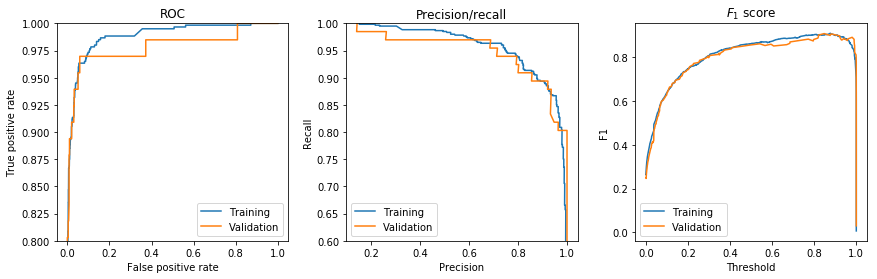

Training statistics:
             precision    recall  f1-score   support

        ham       0.99      0.96      0.98      3857
       spam       0.80      0.94      0.86       601

avg / total       0.96      0.96      0.96      4458

Training classification accuracy: 0.960

Validation statistics:
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98       491
       spam       0.79      0.94      0.86        66

avg / total       0.97      0.96      0.97       557

Validation classification accuracy: 0.964


In [864]:
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, accuracy_score

# Get training/validation predictions
y_train_pred = model[1].predict_proba(X_train_sparse)
y_val_pred = model[1].predict_proba(X_val_sparse)
# Plot ROC curves
def roc_plot(y_train, y_train_pred, y_val, y_val_pred):
    fpr, tpr, _ = roc_curve(y_train, y_train_pred[:,1])
    plt.plot(fpr, tpr, label="Training")
    fpr, tpr, _ = roc_curve(y_val, y_val_pred[:,1])
    plt.plot(fpr, tpr, label="Validation")
    plt.ylim(ymin=0.8, ymax=1)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC")
    plt.legend(loc=4)
# Plot precision/recall curves
def pr_plot(y_train, y_train_pred, y_val, y_val_pred):
    precision, recall, _ = precision_recall_curve(y_train, y_train_pred[:,1])
    plt.plot(precision, recall, label="Training")
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred[:,1])
    plt.plot(precision, recall, label="Validation")
    plt.ylim(ymin=0.6, ymax=1)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.title("Precision/recall")
    plt.legend(loc=3)
def f1_plot(y_train, y_train_pred, y_val, y_val_pred):
    p, r, thresh = precision_recall_curve(y_train, y_train_pred[:,1]); p=p[:-1]; r=r[:-1]
    plt.plot(thresh, 2*p*r/(p+r), label="Training")
    p, r, thresh = precision_recall_curve(y_val, y_val_pred[:,1]); p=p[:-1]; r=r[:-1]
    plt.plot(thresh, 2*p*r/(p+r), label="Validation")
    #plt.ylim(ymin=0.6, ymax=1)
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.title("$F_1$ score")
    plt.legend(loc=3)

plt.subplot(131)
roc_plot(y_train, y_train_pred, y_val, y_val_pred)
plt.subplot(132)
pr_plot(y_train, y_train_pred, y_val, y_val_pred)
plt.subplot(133)
f1_plot(y_train, y_train_pred, y_val, y_val_pred)
plt.subplots_adjust(right=2, wspace=0.25)
plt.show()

# Show classification reports
print("Training statistics:")
print(classification_report(y_train, np.argmax(y_train_pred, axis=1), target_names=["ham", "spam"]))
print("Training classification accuracy: {:.3f}".format(accuracy_score(y_train, np.argmax(y_train_pred, axis=1))))
print("\nValidation statistics:")
print(classification_report(y_val, np.argmax(y_val_pred, axis=1), target_names=["ham", "spam"]))
print("Validation classification accuracy: {:.3f}".format(accuracy_score(y_val, np.argmax(y_val_pred, axis=1))))

This looks pretty good at a first glance; 96% classification accuracy doesn't look too bad. But since there is a class imbalance, accuracy isn't everything. Also, we have to consider the risk of making misclassifications. Specifically, if we want to make sure we're catching all the spam (true positives), we want to make sure we have a high recall (true positive rate). However, we REALLY don't want to misclassify a ham message as spam (false positive), since if a legitimate message is accidentally deleted, it could have grave consequences, whereas if a spam message gets through the filter, it is simply a minor nusiance. As it is now, with a threshold of 0.5, our classifier will catch 91% of the spam, and incorrectly identifies ham messages 2% of the time, which doesn't sound bad. But the fraction of messages which it classifies as spam that are actually ham is as high as 20%!

In [865]:
thresh = 0.5
print("Fraction of ham messages incorrectly identified as spam (FPR): {:.4f}".format(np.mean(y_val_pred[y_val==0][:,1] > thresh)))
print("Fraction of spam messages correctly identified (TPR): {:.4f}".format(np.mean(y_val_pred[y_val==1][:,1] > thresh)))
print("Fraction of messages identified as spam which are actually ham (FDR): {:.4f}".format(np.mean(y_val[y_val_pred[:,1]>thresh] == 0)))

Fraction of ham messages incorrectly identified as spam (FPR): 0.0326
Fraction of spam messages correctly identified (TPR): 0.9394
Fraction of messages identified as spam which are actually ham (FDR): 0.2051


Our primary goal is to minimize the number of false positives. Since the ratio of ham:spam is already relatively large (about 6:1), we don't expect to be making a lot of positive identifications anyway. Therefore, the false positive rate ($FPR=FP/N$) is always going to be relatively small, regardless of performance. The false discovery rate ($FDR=FP/(TP+FP)$ or 1-precision), on the other hand, will be relatively large since the denominator $TP+FP$ is smaller than the total number of negative examples $N=TN+FP$. So minimizing the FDR should be our primary goal. This is equivalent to maximizing the precision ($TP/(TP+FP)$), but large relative changes in small FDR may not amount to significant changes in precision (like changing FDR from 0.01 -> 0.03 only changes precision from 0.99 -> 0.97). However, in the end, we really don't want to end up throwing a large fraction of legitimate messages away, so FPR will be useful to us as a constraint (e.g. don't want to discard any more than 1/1000 ham messages).

Our secondary goal is to positively identify as much actual spam as possible. This is simply measured by the recall or true positive rate $TPR=TP/T=TP/(TP+FN)$.

Ideally, we would be able to combine these two metrics (1/FDR and TPR) into a single one so that we may measure performance at a glance, but since $1/FDR \in [1, \infty)$ and $TPR \in [0,1]$, this does not seem feasible. However, what we can do is try to maximize recall, while maintaining a constraint on the false positive rate. To evaluate our model using this metric, we can plot FPR vs TPR vs different thresholds (the typical ROC curve) on a semilog plot, decide on a maximum allowable cutoff for the FPR (which determines the classification threshold), and then check the TPR at this threshold. Let's see how our current model is evaluated using this metric:

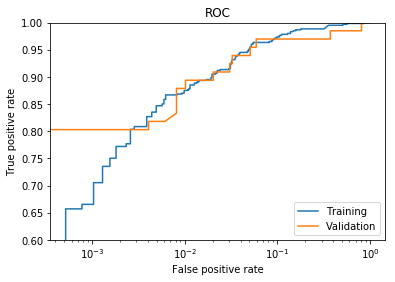

In [792]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred[:,1])
plt.semilogx(fpr, tpr, label="Training")
fpr, tpr, _ = roc_curve(y_val, y_val_pred[:,1])
plt.semilogx(fpr, tpr, label="Validation")
plt.ylim(ymin=0.6, ymax=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC")
plt.legend(loc=4)
plt.show()

I think a false positive rate of 1 in 100 (0.01) is probably a pretty good constraint (also our validation set only has ~500 samples in it so it's impossible to measure an FPR less than ~1/500). We'll use that from now on. Looks like this corresponds to a recall of roughly 0.80-0.85. Let's write a function to do the evaluation for us:

In [793]:
def evaluate_model(model, X, y, FPR_max=0.01):
    # Find y_pred
    y_pred = model.predict_proba(X)
    
    # Get FPR, TPR, and thresholds from sklearn's roc_curve function
    fpr, tpr, thresh = roc_curve(y, y_pred[:,1])
    
    # Find the threshold with the largest FPR below the max
    for i in reversed(range(len(fpr))):
        if fpr[i] <= FPR_max: break
    return fpr[i], tpr[i], thresh[i]
print("Training - FPR={:.3e}, TPR={:.3f}, thresh={:.3f}".format(*evaluate_model(model[1], X_train_sparse, y_train)))
print("Validation - FPR={:.3e}, TPR={:.3f}, thresh={:.3f}".format(*evaluate_model(model[1], X_val_sparse, y_val)))

Training - FPR=9.852e-03, TPR=0.875, thresh=0.824
Validation - FPR=8.147e-03, TPR=0.879, thresh=0.880


Now that we have our metric down we should start tuning hyperparameters. I'll just roll the dice on a random set of hyperparameters a number of times, evaluate them using k-fold cross-validation, then pick the best model.

In [830]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=None)

best_hyperparameters = None
best_tpr = 0
X = sp.sparse.vstack([X_train_sparse, X_val_sparse]).todok()
y = np.concatenate([y_train, y_val], axis=0)

for _ in range(100):
    # Pick hyperparameters
    C = 10**np.random.uniform(-2,2)
    spam_weight = np.random.uniform(0.5, 10)
    penalty = np.random.choice(["l1", "l2"])
    
    # Instantiate, train, and evaluate model using k-fold CV
    tpr_list = []
    for train_idx, val_idx in kf.split(X):
        temp_model = LogisticRegression(penalty=penalty, C=C, solver="liblinear", class_weight={0:1, 1:spam_weight})
        temp_model.fit(X[train_idx], y[train_idx])
        fpr, tpr, thresh = evaluate_model(temp_model, X[val_idx], y[val_idx])
        tpr_list.append(tpr)
    if np.mean(tpr_list) > best_tpr:
        best_tpr = np.mean(tpr_list)
        best_hyperparameters = (C, spam_weight, penalty)
        print("Model {}: FPR={:.3e}, TPR={:.3f}\u00B1{:.3f}, thresh={:.3f}".format(_, fpr, best_tpr, 2*np.std(tpr_list), thresh), end="\n")

Model 0: FPR=9.174e-03, TPR=0.849±0.069, thresh=0.921
Model 2: FPR=9.335e-03, TPR=0.859±0.070, thresh=0.532
Model 17: FPR=9.259e-03, TPR=0.860±0.041, thresh=0.774
Model 87: FPR=5.807e-03, TPR=0.866±0.052, thresh=0.633
Model 94: FPR=8.226e-03, TPR=0.873±0.056, thresh=0.679


In [870]:
C, spam_weight, penalty = best_hyperparameters
model[2] = LogisticRegression(penalty=penalty, C=C, solver="liblinear", class_weight={0:1, 1:spam_weight})
model[2].fit(X_train_sparse, y_train)
print("C={:.2e}, spam_weight={:.2f}, penalty={}".format(*best_hyperparameters))
for FPR_max in [1/2, 1/10, 1/100, 1/1000]:
    print("Test set: FPR={:.4f}, TPR={:.3f}, threshold={:.3f}".format(*evaluate_model(model[2], X_test_sparse, y_test, FPR_max=FPR_max)))

C=9.16e-01, spam_weight=3.00, penalty=l1
Test set: FPR=0.4864, TPR=0.988, threshold=0.013
Test set: FPR=0.0964, TPR=0.938, threshold=0.104
Test set: FPR=0.0042, TPR=0.825, threshold=0.857
Test set: FPR=0.0000, TPR=0.750, threshold=0.964


We have a recall of 82.5% and a false positive rate of <1% on the test set (which has been completely blinded up until this point). Looking around for other studies/implementations to benchmark against, I found [this study](https://arxiv.org/abs/cs/0009009), which compared several spam filtering techniques. For comparison, our constraint of max FPR of 1/100 would be roughly comparable to one of their models with parameter $\lambda = 100$ (this comparison falls apart for $\lambda\sim 1$). The value of $\lambda$ can be understood as the relative cost of misclassifying ham as spam vs misclassifying spam as ham - it is $\lambda$ times worse to make a false positive identification than a false negative. As we can see from their Table 1, our logistic regression model outperforms all the models they considered with regards to spam recall (TPR) for equivalent values of $\lambda$.